# Neural Style Transfer with PyTorch
This notebook demonstrates neural style transfer using PyTorch. The goal is to generate a new image that combines the content of one image with the artistic style of another. The implementation is based on the work of Gatys et al. (2015) and uses a pre-trained VGG19 network for feature extraction.

## 1. Import Libraries and Set Device
This cell imports all necessary libraries:
- **PyTorch** for deep learning operations
- **torchvision** for image transformations and pretrained models
- **PIL** for image loading and manipulation
- **matplotlib** for image visualization

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import os
import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 2. Image Loader and Display Functions
Defines two utility functions:
- `image_loader(image_name)`: Loads an image from disk, resizes it, converts it to a tensor, and moves it to the selected device. This prepares the image for input to the neural network.
- `imshow(tensor, title=None)`: Converts a tensor back to a PIL image and displays it using matplotlib. Useful for visualizing intermediate and final results.

In [5]:

imsize = 512 if torch.cuda.is_available() else 256

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    unloader = transforms.ToPILImage()
    plt.imshow(unloader(image))
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


## 3. Load and Display Content and Style Images
Loads the content and style images from disk using the loader function. Checks that both images have the same size (required for style transfer) and displays them for visual confirmation. This step ensures the input images are correctly prepared before processing.

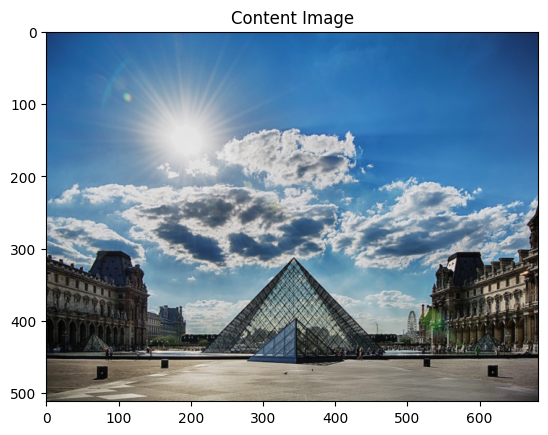

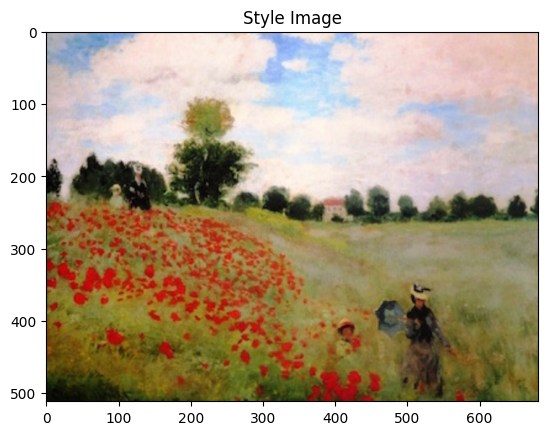

In [6]:

content_img = image_loader("images/louvre.jpg")
style_img = image_loader("images/monet.jpg")

assert content_img.size() == style_img.size() 

plt.figure()
imshow(content_img, title="Content Image")
plt.figure()
imshow(style_img, title="Style Image")


## 4. Content and Style Loss Classes, Gram Matrix
Defines:
- `ContentLoss`: Computes the mean squared error between the target content features and the generated image features.
- `StyleLoss`: Computes the mean squared error between the Gram matrices of the target style features and the generated image features.
- `gram_matrix`: Calculates the Gram matrix, which captures the correlations between feature maps and is used to represent style.

In [7]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x


## 5. VGG Model, Normalization, and Model Construction
- Loads the pretrained VGG19 model from torchvision and extracts its feature layers.
- Defines a `Normalization` class to normalize input images as required by VGG.
- Builds a new model by inserting content and style loss layers at appropriate points in the network. This model is used to compute losses during optimization.

In [8]:

cnn = models.vgg19(pretrained=True).features.to(device).eval()

content_layers = ["conv_4"]
style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]

    return model, style_losses, content_losses


c:\Users\Kaveh\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kaveh\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 6. Style Transfer Optimization Loop
- Defines the optimizer (LBFGS) for updating the input image.
- Implements the main style transfer loop, which iteratively updates the input image to minimize the combined style and content losses.
- Prints loss values during optimization and displays the final stylized output image.

Building the style transfer model..
Optimizing..
Run 50:
Style Loss: 46.224255 Content Loss: 15.630846
Run 100:
Style Loss: 29.177172 Content Loss: 11.954907
Run 150:
Style Loss: 21.870554 Content Loss: 10.500028
Run 200:
Style Loss: 13.892228 Content Loss: 10.487992
Run 250:
Style Loss: 8.256011 Content Loss: 10.204916
Run 300:
Style Loss: 5.110973 Content Loss: 9.731565


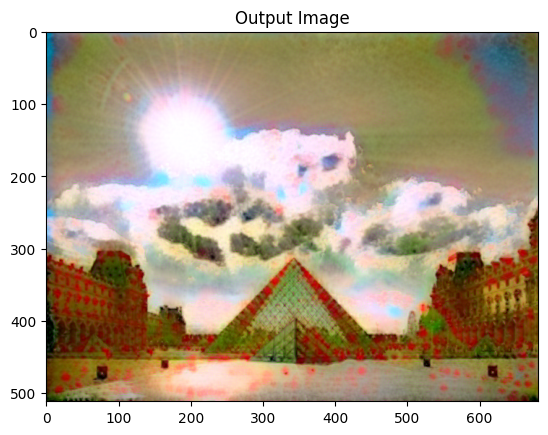

In [9]:

input_img = content_img.clone()

def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1e6, content_weight=1):
    print("Building the style transfer model..")
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, normalization_mean, normalization_std, style_img, content_img
    )
    optimizer = get_input_optimizer(input_img)

    print("Optimizing..")
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Run {run[0]}:")
                print(f"Style Loss: {style_score.item():4f} Content Loss: {content_score.item():4f}")
            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title="Output Image")
plt.ioff()
plt.show()


## 7. Resize Images, Run Style Transfer, and Save Output
- Dynamically resizes both content and style images to match the content image's size using a helper function.
- Runs the style transfer process with the prepared images.
- Displays the generated image and saves it to disk with a unique, timestamped filename to avoid overwriting previous results.

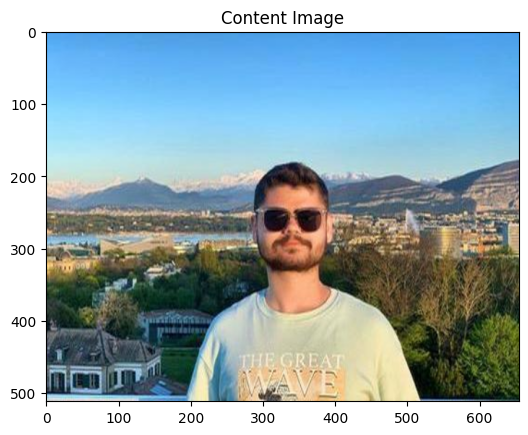

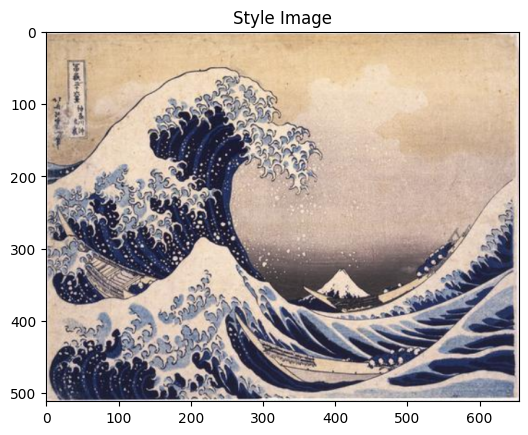

Building the style transfer model..
Optimizing..
Run 50:
Style Loss: 27.067228 Content Loss: 11.789278
Run 100:
Style Loss: 5.682654 Content Loss: 10.842900
Run 150:
Style Loss: 2.674432 Content Loss: 9.350679
Run 200:
Style Loss: 1.725960 Content Loss: 8.362790
Run 250:
Style Loss: 1.305383 Content Loss: 7.778501
Run 300:
Style Loss: 1.041765 Content Loss: 7.392765


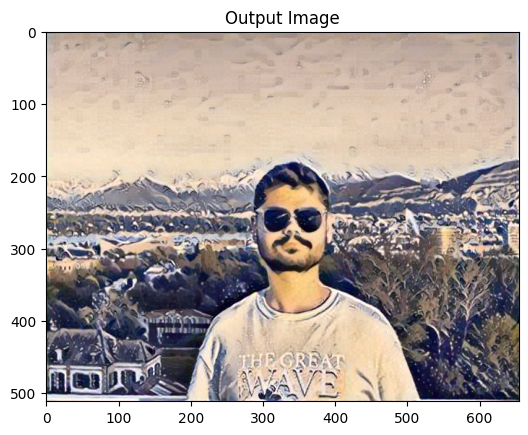

Generated image saved at: generated_images/output_20250903_114814.png


In [10]:
def resize_and_save(image_path, size):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size, Image.LANCZOS)
    img.save(image_path)

def get_image_size(image_path):
    img = Image.open(image_path)
    return img.size  # (width, height)

# Get size of content image
content_image_path = "images/Kaveh_Geneva.jpg"
style_image_path = "images/great-wave.jpg"
fixed_size = get_image_size(content_image_path)


# Resize both images to content image size
resize_and_save(content_image_path, fixed_size)
resize_and_save(style_image_path, fixed_size)

my_content_path = content_image_path
my_style_path = style_image_path

content_img = image_loader(my_content_path)
style_img = image_loader(my_style_path)
input_img = content_img.clone()

imshow(content_img, title="Content Image")
imshow(style_img, title="Style Image")

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

imshow(output, title="Output Image")

# Create output folder if not exists
os.makedirs("generated_images", exist_ok=True)

# Save result with dynamic filename
unloader = transforms.ToPILImage()
image = output.cpu().clone().squeeze(0)
image = unloader(image)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"generated_images/output_{timestamp}.png"
image.save(save_path)
print(f"Generated image saved at: {save_path}")
